# Laden der Rohdaten

In [ ]:
import pickle

# Laden der 'kirp' Liste aus der Pickle-Datei
with open('rick.pickle', 'rb') as f:
    data_frame = pickle.load(f)

# Aktiviere Cuda Support

In [ ]:
import torch
device = "cpu"
if torch.cuda.is_available():
    print("CUDA is available on your system.")
    device = "cuda"
else:
    print("CUDA is not available on your system.")

# PCA Klasse zu Reduktion der Dimensionen

In [ ]:
from torch.utils.data import Dataset
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from typing import List, Tuple, Dict


class GenomeDataset(Dataset):
    """
    Eine benutzerdefinierte Dataset-Klasse, die für die Handhabung von Genomdaten konzipiert ist.
    Diese Klasse wendet eine Principal Component Analysis (PCA) auf die Frequenzen der Genome an
    und teilt den Datensatz in Trainings- und Validierungsteile auf.

    Attributes:
        dataframe (pd.DataFrame): Ein Pandas DataFrame, der die initialen Daten enthält.
        train_df (pd.DataFrame): Ein DataFrame, der den Trainingsdatensatz nach der Anwendung von PCA und der Aufteilung enthält.
        val_df (pd.DataFrame): Ein DataFrame, der den Validierungsdatensatz nach der Anwendung von PCA und der Aufteilung enthält.

    Methods:
        __init__(self, dataframe, n_pca_components=1034, train_size=0.8, split_random_state=42):
            Konstruktor für die GenomeDataset Klasse.
        _do_PCA(self, frequencies, n_components=1034):
            Wendet PCA auf die gegebenen Frequenzen an.
        _split_dataset(self, train_size=0.8, random_state=42):
            Teilt den DataFrame in Trainings- und Validierungsdatensätze auf.
        __getitem__(self, index):
            Gibt ein Tupel aus transformierten Frequenzen und dem zugehörigen Krebstyp für einen gegebenen Index zurück.
        __len__(self):
            Gibt die Gesamtlänge der kombinierten Trainings- und Validierungsdatensätze zurück.
    """

    def __init__(self, dataframe: pd.DataFrame, n_pca_components: int = 1034, train_size: float = 0.8, split_random_state: int = 42):
        """
        Konstruktor für die GenomeDataset Klasse.

        Parameters:
            dataframe (pd.DataFrame): Der DataFrame, der die Genome Frequenzen und Krebsarten enthält.
            n_pca_components (int): Die Anzahl der PCA-Komponenten, auf die reduziert werden soll. Standardwert ist 1034.
            train_size (float): Der Anteil der Daten, der als Trainingsdaten verwendet werden soll. Standardwert ist 0.8.
            split_random_state (int): Der Zufalls-Saatwert, der für die Aufteilung des Datensatzes verwendet wird. Standardwert ist 42.
        """
        self.dataframe = dataframe

        # Umwandlung der Krebsarten in numerische Werte
        self.label_encoder = LabelEncoder()
        self.dataframe['encoded_cancer_type'] = self.label_encoder.fit_transform(dataframe['cancer_type'])

        # Anwenden der PCA auf die Frequenzen
        self.dataframe['pca_frequencies'] = self._do_PCA(self.dataframe['genome_frequencies'].tolist(), n_pca_components)

        # Teilen des DataFrame in Trainings- und Validierungsdatensatz
        self._split_dataset(train_size=train_size, random_state=split_random_state)

    def transform_datapoint(self, datapoint: List[float]) -> List[float]:
        """
        Transformiert einen einzelnen Datenpunkt durch Standardisierung und Anwendung der PCA.

        Diese Methode nimmt einen rohen Datenpunkt (eine Liste von Frequenzen), standardisiert ihn mit dem 
        zuvor angepassten Scaler und wendet dann die PCA-Transformation an, um ihn in den reduzierten 
        Feature-Raum zu überführen, der für das Training des Modells verwendet wurde.

        Parameters:
            datapoint (List[float]): Ein roher Datenpunkt, bestehend aus einer Liste von Frequenzen.

        Returns:
            List[float]: Der transformierte Datenpunkt, nach Anwendung der Standardisierung und der PCA.
        """
        # Standardisierung des Datenpunkts
        scaled_data_point = self.scaler.transform([datapoint])

        # PCA-Transformation des standardisierten Datenpunkts
        pca_transformed_point = self.pca.transform(scaled_data_point)

        return pca_transformed_point.tolist()

    def _do_PCA(self, frequencies: List[List[float]], n_components: int = 1034) -> List[List[float]]:
        """
        Wendet PCA auf die gegebenen Frequenzen an.

        Parameters:
            frequencies (List[List[float]]): Die Liste der Frequenzen, auf die die PCA angewendet werden soll.
            n_components (int): Die Anzahl der Komponenten für die PCA. Standardwert ist 1034.

        Returns:
            List[List[float]]: Eine Liste von Listen, die die transformierten Frequenzen nach der PCA darstellt.
        """

        # Standardisieren der Frequenzen
        self.scaler = StandardScaler()
        scaled_frequencies = self.scaler.fit_transform(frequencies)

        # PCA-Instanz erstellen und auf die gewünschte Anzahl von Komponenten reduzieren
        self.pca = PCA(n_components=n_components)

        # PCA auf die Frequenzen anwenden
        pca_result = self.pca.fit_transform(scaled_frequencies)

        return pca_result.tolist()

    def _split_dataset(self, train_size: float = 0.8, random_state: int = 42):
        """
        Teilt den DataFrame in Trainings- und Validierungsdatensätze auf.

        Parameters:
            train_size (float): Der Anteil der Daten, der als Trainingsdaten verwendet werden soll.
            random_state (int): Der Zufalls-Saatwert, der für die Aufteilung des Datensatzes verwendet wird.
        """

        class SplittedDataset(Dataset):
            def __init__(self, dataframe):
                self.dataframe = dataframe

                # Umwandlung der Genome Frequenzen in Tensoren
                self.genome_frequencies = torch.tensor(dataframe['pca_frequencies'].tolist(), dtype=torch.float32)

                # Umwandlung der Krebsarten in numerische Werte
                self.label_encoder = LabelEncoder()
                self.cancer_types = torch.tensor(dataframe['encoded_cancer_type'].tolist(), dtype=torch.long)

            def __getitem__(self, index):
                # Rückgabe eines Tupels aus Genome Frequenzen und dem entsprechenden Krebstyp
                return self.genome_frequencies[index], self.cancer_types[index]

            def __len__(self):
                return len(self.dataframe)

        # Teilen des DataFrame in Trainings- und Validierungsdatensatz
        train_df, val_df = train_test_split(self.dataframe, train_size=train_size) #, random_state=random_state)
        self.train_df = SplittedDataset(train_df)
        self.val_df = SplittedDataset(val_df)


    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Gibt ein Tupel aus transformierten Frequenzen und dem entsprechenden Krebstyp für einen gegebenen Index zurück.

        Parameters:
            index (int): Der Index des zu abrufenden Datenelements.

        Returns:
            Tuple[torch.Tensor, int]: Ein Tupel, bestehend aus einem Tensor der transformierten Frequenzen und dem zugehörigen Krebstyp.
        """

        print(self.train_df.shape)
        print(self.val_df.shape)
        
        if index < len(self.train_df):
            row = self.train_df.iloc[index]
        else:
            row = self.val_df.iloc[len(self.train_df) - index]

        pca_frequencies_tensor = torch.tensor(row['pca_frequencies'], dtype=torch.float32)
        cancer_type = row['encoded_cancer_type']

        return pca_frequencies_tensor, cancer_type

    def __len__(self) -> int:
        """
        Gibt die Gesamtlänge der kombinierten Trainings- und Validierungsdatensätze zurück.

        Returns:
            int: Die Länge der kombinierten Datensätze.
        """
        
        return len(self.train_df) + len(self.val_df)


# Definition des neuronalen Netzes

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CancerClassifierNN(nn.Module):
    """
    Eine benutzerdefinierte neuronale Netzwerkklassifikator-Klasse für die Krebsklassifikation.

    Diese Klasse definiert ein mehrschichtiges Perzeptron (MLP), das für die Klassifizierung von Krebsarten
    anhand genetischer Frequenzdaten verwendet wird.

    Attributes:
        fc1 (nn.Linear): Die erste lineare Schicht des Netzwerks.
        fc2 (nn.Linear): Die zweite lineare Schicht des Netzwerks.
        fc3 (nn.Linear): Die dritte lineare Schicht des Netzwerks.
        fc4 (nn.Linear): Die Ausgabeschicht des Netzwerks.
        dropout (nn.Dropout): Ein Dropout-Layer zur Vermeidung von Overfitting.

    Methods:
        __init__(self, input_size: int, num_classes: int):
            Konstruktor für die CancerClassifierNN Klasse.
        forward(self, x: torch.Tensor) -> torch.Tensor:
            Definiert den Vorwärtsdurchlauf des Netzwerks.
    """

    def __init__(self, input_size: int, num_classes: int):
        """
        Konstruktor für die CancerClassifierNN Klasse.

        Parameters:
            input_size (int): Die Größe des Input-Features.
            num_classes (int): Die Anzahl der Zielklassen.
        """
        super(CancerClassifierNN, self).__init__()
        # Definieren der Schichten
        self.fc1 = nn.Linear(input_size, input_size)  # Eingabeschicht
        self.fc2 = nn.Linear(input_size, input_size//2)        # Versteckte Schicht
        self.fc3 = nn.Linear(input_size//2, input_size//4)         # Weitere versteckte Schicht
        self.fc4 = nn.Linear(input_size//4, num_classes) # Ausgabeschicht
        self.dropout = nn.Dropout(p=0.5)       # Dropout

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Definiert den Vorwärtsdurchlauf des Netzwerks.

        Parameters:
            x (torch.Tensor): Der Input-Tensor für das Netzwerk.

        Returns:
            torch.Tensor: Der Output-Tensor nach dem Durchlauf durch das Netzwerk.
        """
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.softmax(self.fc4(x), dim=1)  # Oder F.log_softmax(x, dim=1) für Mehrklassenklassifikation
        return x

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

class ExperimentationalExperiments():
    """
    Diese Klasse dient zur Durchführung und Verwaltung von Experimenten im Rahmen
    des maschinellen Lernens, insbesondere für die Krebsklassifikation.

    Attribute:
    results : Dict
        Speichert die Ergebnisse der durchgeführten Experimente.
    """

    def __init__(self) -> None:
        """ Konstruktor der Klasse. Initialisiert 'results' als None. """
        self.results = None

    def run_single_experiment(self, train_loader: DataLoader, valid_loader: DataLoader, n_pca_components: int, n_epochs: int = 200, learning_rate: int = 0.0005, verbose: bool = True, experiment_num: int = None) -> Tuple:
        """
        Führt ein einzelnes Experiment mit dem spezifizierten DataLoader, PCA-Komponenten und weiteren Parametern durch.

        Parameter:
        train_loader : DataLoader
            Der DataLoader für den Trainingsdatensatz.
        valid_loader : DataLoader
            Der DataLoader für den Validierungsdatensatz.
        n_pca_components : int
            Anzahl der PCA-Komponenten, die im Modell verwendet werden.
        n_epochs : int, optional
            Anzahl der Epochen für das Training (Standardwert ist 200).
        learning_rate : float, optional
            Lernrate für den Optimierer (Standardwert ist 0.0005).
        verbose : bool, optional
            Gibt an, ob der Trainingsfortschritt angezeigt werden soll (Standardwert ist True).
        experiment_num : int, optional
            Nummer des Experiments.

        Rückgabewerte:
        Tuple
            Ein Tupel bestehend aus Listen der Trainings- und Validierungsverluste sowie der Genauigkeiten.
        """
        if not isinstance(n_pca_components, int):
            raise TypeError("n_pca_components must be an integers!")

        model = CancerClassifierNN(input_size=n_pca_components, num_classes=3)
        model.to(device=device)

        # Verlustfunktion
        criterion = nn.CrossEntropyLoss()
        # Optimierer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Listen, um Verluste zu speichern
        train_losses = []
        valid_losses = []
        train_accuracies = []
        valid_accuracies = []

        for epoch in range(n_epochs):
            model.train()
            train_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                # Berechnen der Genauigkeit
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_predictions += labels.size(0)

            # Durchschnittlicher Trainingsverlust und Genauigkeit
            train_loss /= len(train_loader)
            train_accuracy = correct_predictions / total_predictions
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Validierungsverlust und Genauigkeit
            model.eval()
            valid_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    valid_loss += loss.item()

                    # Berechnen der Genauigkeit
                    _, predicted = torch.max(outputs, 1)
                    correct_predictions += (predicted == labels).sum().item()
                    total_predictions += labels.size(0)

            # Durchschnittlicher Validierungsverlust und Genauigkeit
            valid_loss /= len(valid_loader)
            valid_accuracy = correct_predictions / total_predictions
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_accuracy)

            # Aktualisieren des Graphen
            clear_output(wait=True)
            fig, ax1 = plt.subplots()

            # Zeichnen der Verlustkurven
            ax1.plot(train_losses, label='Trainingsverlust', color='r')
            ax1.plot(valid_losses, label='Validierungsverlust', color='b')
            ax1.set_xlabel('Epochen')
            ax1.set_ylabel('Verlust', color='g')
            ax1.tick_params(axis='y', labelcolor='g')

            # Zweite y-Achse für die Genauigkeit
            ax2 = ax1.twinx()
            ax2.plot(train_accuracies, label='Trainingsgenauigkeit', color='r', linestyle='dashed')
            ax2.plot(valid_accuracies, label='Validierungsgenauigkeit', color='b', linestyle='dashed')
            ax2.set_ylabel('Genauigkeit', color='g')
            ax2.tick_params(axis='y', labelcolor='g')

            # Titel und Legende
            plt.title(f'Experiment #{experiment_num}: Trainings- und Validierungsverlust und -genauigkeit über die Zeit mit \n{n_pca_components}-Hauptkomponenten, Lernrate: {learning_rate}')
            fig.tight_layout()

            # Legende außerhalb des Graphen
            ax1.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
            ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.85))

            # Fortschritt anzeigen, falls angegeben
            if verbose:
                print(f'Experiment #{experiment_num} mit {n_pca_components} PCA components: Epoch [{epoch+1}/{n_epochs}], Trainingsverlust: {train_loss:.4f}, Trainingsgenauigkeit: {train_accuracies[-1]:.4f}, Validierungsverlust: {valid_loss:.4f}, Validierungsgenauigkeit: {valid_accuracies[-1]:.4f}')

        # Plot speichern
        name = str(experiment_num) + ".png" if experiment_num is not None else "single_experiment.png"
        if not os.path.exists("Experiments"):
            os.makedirs("Experiments")
        if not os.path.exists(f"Experiments/{str(n_pca_components)}"):
            os.makedirs(f"Experiments/{str(n_pca_components)}")
        plt.savefig(f"Experiments/{str(n_pca_components)}/{name}", bbox_inches='tight')

        return train_losses, valid_losses, train_accuracies, valid_accuracies

    def run_single_pca_experiment(self, train_loader: DataLoader, valid_loader: DataLoader, n_pca_components: int, n_experiments: int, n_epochs: int = 200, learning_rate: int = 0.0005, verbose: bool = True) -> List:
        """
        Führt eine Serie von Experimenten mit verschiedenen Konfigurationen für die PCA-Komponenten durch.

        Parameter:
        train_loader : DataLoader
            Der DataLoader für den Trainingsdatensatz.
        valid_loader : DataLoader
            Der DataLoader für den Validierungsdatensatz.
        n_pca_components : int
            Anzahl der PCA-Komponenten, die im Modell verwendet werden.
        n_experiments : int
            Anzahl der durchzuführenden Experimente.
        n_epochs : int, optional
            Anzahl der Epochen für das Training (Standardwert ist 200).
        learning_rate : float, optional
            Lernrate für den Optimierer (Standardwert ist 0.0005).
        verbose : bool, optional
            Gibt an, ob der Trainingsfortschritt angezeigt werden soll (Standardwert ist True).

        Rückgabewerte:
        List
            Eine Liste von Ergebnissen der einzelnen Experimente.
        """
        if not isinstance(n_pca_components, int):
            raise TypeError("n_pca_components must be an integers!")

        results = []

        for n in range(n_experiments):
            res = self.run_single_experiment(train_loader, valid_loader, n_pca_components, n_epochs=n_epochs, learning_rate=learning_rate, verbose=verbose, experiment_num=n+1)
            results.append(res)

        return results
            

    def run(self, n_pca_components: List[int], n_experiments: int, n_epochs: int = 200, learning_rate: int = 0.0005, batch_size: int = 64, verbose: bool = True) -> Dict:
        """
        Hauptmethode zum Ausführen von Experimenten mit verschiedenen Anzahlen von PCA-Komponenten.

        Parameter:
        n_pca_components : List[int]
            Eine Liste von Anzahlen der PCA-Komponenten, die in den Experimenten verwendet werden sollen.
        n_experiments : int
            Anzahl der durchzuführenden Experimente pro PCA-Komponentenanzahl.
        n_epochs : int, optional
            Anzahl der Epochen für das Training (Standardwert ist 200).
        learning_rate : float, optional
            Lernrate für den Optimierer (Standardwert ist 0.0005).
        batch_size : int, optional
            Batch-Größe für das Laden der Daten (Standardwert ist 64).
        verbose : bool, optional
            Gibt an, ob der Trainingsfortschritt angezeigt werden soll (Standardwert ist True).

        Rückgabewerte:
        Dict
            Ein Wörterbuch, das die Ergebnisse der Experimente für jede Anzahl von PCA-Komponenten enthält.
        """
        if not isinstance(n_pca_components, list):
            raise TypeError("n_pca_components must be a list of integers!")

        plt.ioff()
        self.n_pca_components = n_pca_components

        results = {}

        for n_pca_comps in n_pca_components:
            genome_dataset = GenomeDataset(data_frame, n_pca_components=n_pca_comps)
            train_dataset = genome_dataset.train_df
            valid_dataset = genome_dataset.val_df

            train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
            valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

            res = self.run_single_pca_experiment(train_loader, valid_loader, n_pca_comps, n_experiments, n_epochs=n_epochs, learning_rate=learning_rate, verbose=verbose)
            results[str(n_pca_comps)] = res

            self.plot_and_save_results(res, n_pca_comps)

        self.results = results

        # Speichern der Daten in einer lokalen Datei
        if len(n_pca_components) > 1:
            with open('Experiments/results.pickle', 'wb') as f:
                pickle.dump(self.results, f)
        else:
            with open(f'Experiments/{str(n_pca_components[0])}/results_{str(n_pca_components[0])}.pickle', 'wb') as f:
                pickle.dump(self.results, f)

        plt.ion()

        return results

    def plot_and_save_results(self, results: List[Tuple], n_pca_components: int) -> None:
        """
        Erstellt und speichert Plots für die Ergebnisse der Experimente.

        Parameter:
        results : List[Tuple]
            Eine Liste von Tupeln mit den Ergebnissen der Experimente.
        n_pca_components : int
            Anzahl der PCA-Komponenten, für die die Ergebnisse geplottet werden sollen.

        Keine Rückgabewerte, da die Methode Plots speichert.
        """
        
        # Mittelwerte und Standardabweichungen berechnen
        train_losses, valid_losses, train_accuracies, valid_accuracies = zip(*results)

        train_losses = np.array(train_losses)
        valid_losses = np.array(valid_losses)
        train_accuracies = np.array(train_accuracies)
        valid_accuracies = np.array(valid_accuracies)

        avg_train_losses = np.mean(train_losses, axis=0)
        avg_valid_losses = np.mean(valid_losses, axis=0)
        avg_train_acc = np.mean(train_accuracies, axis=0)
        avg_valid_acc = np.mean(valid_accuracies, axis=0)

        std_train_losses = np.std(train_losses, axis=0)
        std_valid_losses = np.std(valid_losses, axis=0)
        std_train_acc = np.std(train_accuracies, axis=0)
        std_valid_acc = np.std(valid_accuracies, axis=0)

        # Erstellen von Plots
        epochs = range(1, len(avg_train_losses) + 1)

        # Plot für Verluste
        plt.clf()
        plt.plot(epochs, avg_train_losses, label='Mittlerer Trainingsverlust', color='r')
        plt.fill_between(epochs, np.subtract(avg_train_losses, std_train_losses), np.add(avg_train_losses, std_train_losses), color='r', alpha=0.2)
        plt.plot(epochs, avg_valid_losses, label='Mittlerer Validierungsverlust', color='b')
        plt.fill_between(epochs, np.subtract(avg_valid_losses, std_valid_losses), np.add(avg_valid_losses, std_valid_losses), color='b', alpha=0.2)
        plt.title(f'Mittelwert und Standardabweichung der Verluste für {n_pca_components} PCA-Komponenten')
        plt.xlabel('Experiment Nummer')
        plt.ylabel('Verlust')
        plt.legend()
        plt.savefig(f"Experiments/{n_pca_components}/average_losses.png", bbox_inches='tight')
        plt.clf()

        # Plot für Genauigkeiten
        plt.plot(epochs, avg_train_acc, label='Mittlere Trainingsgenauigkeit', color='r')
        plt.fill_between(epochs, np.subtract(avg_train_acc, std_train_acc), np.add(avg_train_acc, std_train_acc), color='r', alpha=0.2)
        plt.plot(epochs, avg_valid_acc, label='Mittlere Validierungsgenauigkeit', color='b')
        plt.fill_between(epochs, np.subtract(avg_valid_acc, std_valid_acc), np.add(avg_valid_acc, std_valid_acc), color='b', alpha=0.2)
        plt.title(f'Mittelwert und Standardabweichung der Genauigkeiten für {n_pca_components} PCA-Komponenten')
        plt.xlabel('Experiment Nummer')
        plt.ylabel('Genauigkeit')
        plt.legend()
        plt.savefig(f"Experiments/{n_pca_components}/average_accuracies.png", bbox_inches='tight')
        plt.clf()

        

# Starten der einzelnen Experimente, da in einer Schleife RAM Probleme auftreten

In [ ]:
e1 = ExperimentationalExperiments()
results = e1.run([1024], 10, n_epochs=500)
del e1

In [ ]:
e2 = ExperimentationalExperiments()
results = e2.run([512], 10, n_epochs=500)
del e2

In [ ]:
e3 = ExperimentationalExperiments()
results = e3.run([256], 10, n_epochs=500)
del e3

In [ ]:
e4 = ExperimentationalExperiments()
results = e4.run([128], 10, n_epochs=500)
del e4

In [ ]:
e5 = ExperimentationalExperiments()
results = e5.run([64], 10, n_epochs=500)
del e5

In [ ]:
e6 = ExperimentationalExperiments()
results = e6.run([32], 10, n_epochs=500)
del e6

In [ ]:
e7 = ExperimentationalExperiments()
results = e7.run([16], 2, n_epochs=10)
del e7

# Lesen der Daten und Erstellen der Mittelwerte und anschließender Auswertung

In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

def load_results(path: str) -> Dict:
    """
    Lädt und konvertiert die Ergebnisse aus Pickle-Dateien in den spezifizierten Verzeichnissen.

    Argumente:
    path (str): Der Pfad zum Basisverzeichnis, das die Ergebnis-Unterverzeichnisse enthält.

    Rückgabe:
    Dict: Ein Dictionary, in dem jeder Schlüssel einer PCA-Komponentenanzahl entspricht und
          dessen Werte Achtertupel aus Durchschnitt und Standardabweichung von Trainingsverlust,
          Validierungsverlust, Trainingsgenauigkeit und Validierungsgenauigkeit sind.
    """

    results = {}

    # Über alle Ordner im Basispfad iterieren
    for directory in os.listdir(path):
        full_path = os.path.join(path, directory)

        # Überprüfen, ob es sich um einen Ordner handelt
        if os.path.isdir(full_path):
            pickle_file = f'results_{directory}.pickle'
            pickle_path = os.path.join(full_path, pickle_file)

            # Überprüfen, ob die Pickle-Datei existiert
            if os.path.isfile(pickle_path):
                # Pickle-Datei laden
                with open(pickle_path, 'rb') as file:
                    results[directory] = pickle.load(file)

    converted_results = {}
    for values in list(results.values()):
        key = list(values.keys())[0]
        value = list(values.values())[0]
        converted_results[key] = value

    return converted_results


def calculate_means_for_n_last(results: Dict, n_last: int) -> Dict:
    """
    Berechnet Durchschnittswerte und Standardabweichungen für die letzten `n_last` Ergebnisse.

    Argumente:
    results (Dict): Ein Dictionary von Ergebnissen, wie von `load_results` zurückgegeben.
    n_last (int): Anzahl der letzten Ergebnisse, die zur Berechnung verwendet werden sollen.

    Rückgabe:
    Dict: Ein Dictionary mit Schlüsseln als PCA-Komponentenanzahlen und Werten als Achtertupel,
          bestehend aus Durchschnitt und Standardabweichung von Trainingsverlust, 
          Validierungsverlust, Trainingsgenauigkeit und Validierungsgenauigkeit.
    """

    assert results is not None
    assert n_last <= len(list(results.values())[0][0][0])

    means_and_stds = {}

    for key, value in results.items():
        train_losses, valid_losses, train_accuracies, valid_accuracies = zip(*value)
        
        train_losses = train_losses[:n_last]      
        valid_losses = valid_losses[:n_last]
        train_accuracies = train_accuracies[:n_last]
        valid_accuracies = valid_accuracies[:n_last]

        avg_train_loss = np.mean(train_losses)#, axis=0)
        avg_valid_loss = np.mean(valid_losses)#, axis=0)
        avg_train_acc = np.mean(train_accuracies)#, axis=0)
        avg_valid_acc = np.mean(valid_accuracies)#, axis=0)

        std_train_loss = np.std(train_losses)#, axis=0)
        std_valid_loss = np.std(valid_losses)#, axis=0)
        std_train_acc = np.std(train_accuracies)#, axis=0)
        std_valid_acc = np.std(valid_accuracies)#, axis=0)

        means_and_stds[key] = (avg_train_loss, std_train_loss, avg_valid_loss, std_valid_loss, avg_train_acc, std_train_acc, avg_valid_acc, std_valid_acc)

    return means_and_stds


def plot_results(results: Dict, show_lines: bool = True) -> None:
    """
    Stellt die Ergebnisse als Fehlerbalkendiagramme dar. Jedes Diagramm zeigt Mittelwert und
    Standardabweichung von Trainings- und Validierungsverlust sowie -genauigkeit. 
    Fügt zusätzlich eine rote Linie für den höchsten Genauigkeitswert und den geringsten Verlustwert hinzu,
    mit einer Beschriftung, die den Schlüssel des entsprechenden höchsten bzw. niedrigsten Werts anzeigt.

    Argumente:
    results (Dict): Ein Dictionary von berechneten Mittelwerten und Standardabweichungen,
                    wie von `calculate_means_for_n_last` zurückgegeben.
    show_lines (bool): Ein flag, das angibt, ob die Maximal- / Minimallinie gezeichnet werden soll.
    """
    # Schlüssel sortieren
    sorted_keys = sorted(results.keys(), key=lambda x: int(x))

    # Listen für das Plotten vorbereiten
    mean_train_loss = [results[k][0] for k in sorted_keys]
    std_train_loss = [results[k][1] for k in sorted_keys]
    mean_validation_loss = [results[k][2] for k in sorted_keys]
    std_validation_loss = [results[k][3] for k in sorted_keys]
    mean_train_accuracy = [results[k][4] for k in sorted_keys]
    std_train_accuracy = [results[k][5] for k in sorted_keys]
    mean_validation_accuracy = [results[k][6] for k in sorted_keys]
    std_validation_accuracy = [results[k][7] for k in sorted_keys]

    # Plotten
    plt.figure(figsize=(12, 8))

    # Verluste
    plt.errorbar(sorted_keys, mean_train_loss, yerr=std_train_loss, label='Trainingverlust', fmt='o', linestyle='--', alpha=0.8)
    plt.errorbar(sorted_keys, mean_validation_loss, yerr=std_validation_loss, label='Validierungsverlust', fmt='o', linestyle='--', alpha=0.8)

    # Genauigkeiten
    plt.errorbar(sorted_keys, mean_train_accuracy, yerr=std_train_accuracy, label='Trainingsgenauigkeit', fmt='x', linestyle='--', alpha=0.8)
    plt.errorbar(sorted_keys, mean_validation_accuracy, yerr=std_validation_accuracy, label='Validierungsgenauigkeit', fmt='x', linestyle='--', alpha=0.8)

    # Gestaltung
    plt.xlabel('Anzahl der PCA Komponenten')
    plt.ylabel('Werte')
    plt.title('Trainings- und Validierungsverlust und -genauigkeit')
    plt.grid(True)

    # Höchste Genauigkeit und geringster Verlust
    highest_accuracy = max(max(mean_train_accuracy), max(mean_validation_accuracy))
    lowest_loss = min(min(mean_train_loss), min(mean_validation_loss))

    # Schlüssel für höchste Genauigkeit und geringsten Verlust finden
    highest_acc_key = sorted_keys[mean_train_accuracy.index(max(mean_train_accuracy))] if max(mean_train_accuracy) > max(mean_validation_accuracy) else sorted_keys[mean_validation_accuracy.index(max(mean_validation_accuracy))]
    lowest_loss_key = sorted_keys[mean_train_loss.index(min(mean_train_loss))] if min(mean_train_loss) < min(mean_validation_loss) else sorted_keys[mean_validation_loss.index(min(mean_validation_loss))]

    plt.legend()

    # Linien und Text für höchste Genauigkeit und geringsten Verlust
    if show_lines:
        plt.axhline(y=highest_accuracy, color='r', linestyle='-', alpha=0.5)
        plt.text(0.95, highest_accuracy, f'Höchste Genauigkeit (PCA: {highest_acc_key})', verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=8, transform=plt.gca().get_yaxis_transform())

        plt.axhline(y=lowest_loss, color='r', linestyle='-', alpha=0.5)
        plt.text(0.95, lowest_loss, f'Geringster Verlust (PCA: {lowest_loss_key})', verticalalignment='top', horizontalalignment='right', color='red', fontsize=8, transform=plt.gca().get_yaxis_transform())
        
        plt.savefig('Endergebnisse_mit_Linien.png')
    else:
        plt.savefig('Endergebnisse_ohne_Linien.png')

    plt.show()

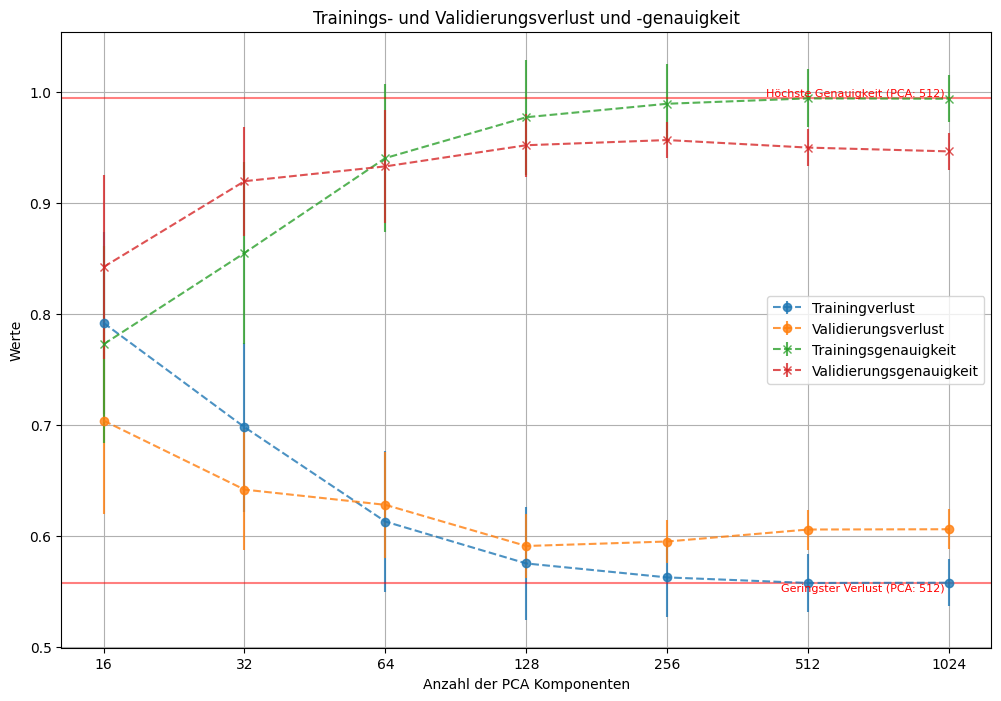

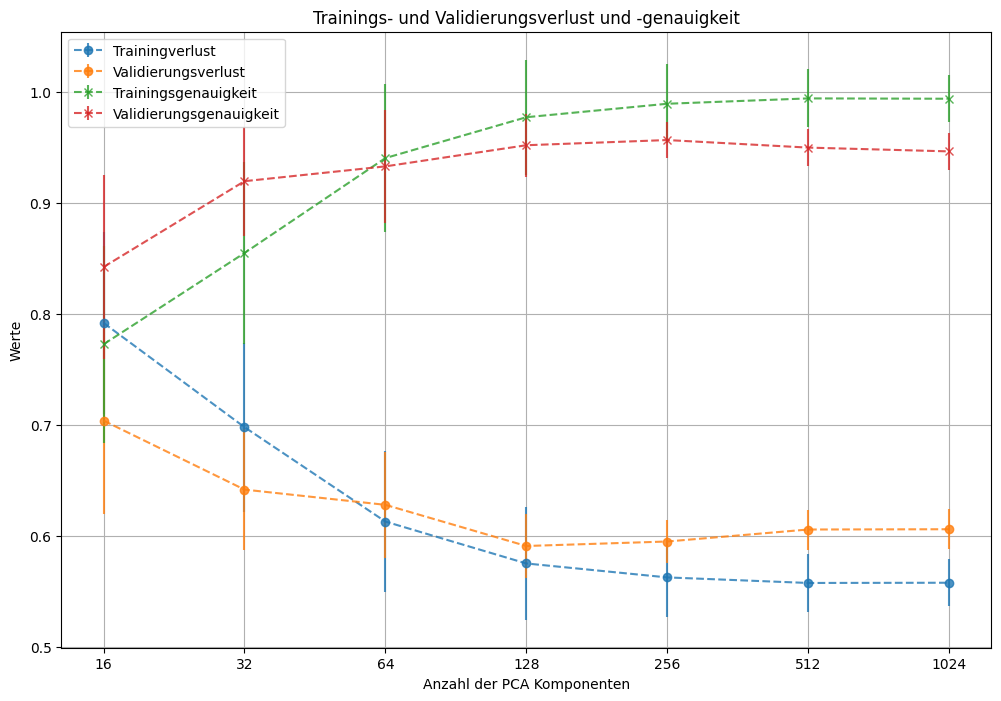

In [3]:

# Ergebnisse laden
base_path = 'Experiments'
loaded_results = load_results(base_path)

# Ergebnisse verarbeiten und plotten
m_a_s = calculate_means_for_n_last(loaded_results, 200)
plot_results(m_a_s)
plot_results(m_a_s, show_lines=False)

In [ ]:
# TODO MNIST datenstaz mit wget ohne tensorflow oder pytorch einlesen